# QMBS

In [127]:
import numpy as np
from qutip import *
from matplotlib import pyplot as plt

In [128]:
N=16

In [129]:
state_list = ([basis(2, 1)] + [basis(2, 0)] + [basis(2, 0)] + [basis(2, 1)])* (int(N/4))
psi0 = tensor(state_list)

# Energy splitting term
omega = 2 * np.pi * np.ones(N)

# Interaction coefficients
Ja = 0.3 * np.pi * np.ones(N)
Je = 0.2 * np.pi * np.ones(N)


In [130]:
sx_list, sy_list, sz_list, sm_list,sp_list = [], [], [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))

# Hamiltonian - transition frequenmcy term
H = 0
for i in range(N):
    H += 0.5 * omega[i] * sp_list[i]*sm_list[i]

# Interaction terms
for n in range(N - 1):
    if n%2 ==0:
        H += -0.5 * Ja[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Ja[n] * sm_list[n] * sp_list[n + 1]
    else:
        H += -0.5 * Je[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Je[n] * sm_list[n] * sp_list[n + 1]
        
# Cross coupling terms



In [142]:
times = np.linspace(0,25,100)
result = sesolve(H,psi0,times)
states = [ result.states]

In [175]:
VNEntropy=[]
fourfidelity = []
rho0=ptrace(psi0,[0,1,2,3])
for Psi_T in result.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    VNEntropy.append(entropy_vn(rho))
    fourfidelity.append(fidelity(rho0,rho))
    
    

In [144]:
exp_sz_t = expect(sz_list, result.states)
exp_sz_0 = expect(sz_list,psi0)
exp_sz_t2=[]
for i in range(len(exp_sz_0)):
    exp_sz_t2.append(exp_sz_0[i]*exp_sz_t[i])
imbalance =  1/N* sum(exp_sz_t2)

In [145]:
exp_sz_0

array([-1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1.])

In [172]:
fidelitylist = []

for i in range(len(result.times)):
    fidelitylist.append(np.vdot(result.states[0],result.states[i])*np.conj(np.vdot(result.states[0],result.states[i])))

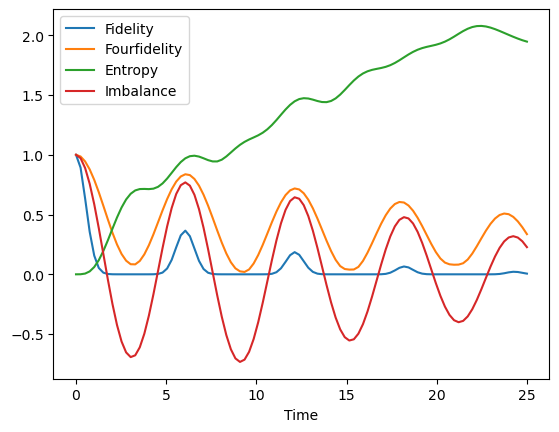

In [177]:
plt.plot(times,fidelitylist,label = 'Fidelity')
plt.plot(times,fourfidelity,label='Fourfidelity')
plt.plot(times,VNEntropy,label = 'Entropy')
plt.plot(times,imbalance, label = 'Imbalance')
plt.xlabel('Time')
plt.legend()


In [155]:
from scipy.fft import fft,fftfreq

In [167]:
intensity = fft(imbalance,n=150)

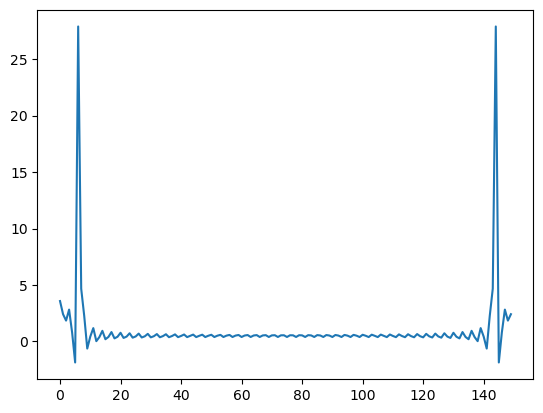

In [168]:
plt.plot(intensity)

In [164]:
freq

array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
        0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
        0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.04,
        1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,  1.4 ,
        1.44,  1.48,  1.52,  1.56,  1.6 ,  1.64,  1.68,  1.72,  1.76,
        1.8 ,  1.84,  1.88,  1.92,  1.96, -2.  , -1.96, -1.92, -1.88,
       -1.84, -1.8 , -1.76, -1.72, -1.68, -1.64, -1.6 , -1.56, -1.52,
       -1.48, -1.44, -1.4 , -1.36, -1.32, -1.28, -1.24, -1.2 , -1.16,
       -1.12, -1.08, -1.04, -1.  , -0.96, -0.92, -0.88, -0.84, -0.8 ,
       -0.76, -0.72, -0.68, -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44,
       -0.4 , -0.36, -0.32, -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08,
       -0.04])

In [178]:
psi0


Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (65536, 1), type = ket
Qobj data =
  (39321, 0)	(1+0j)